# Prepare raw data for curvecurator

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pubchempy as pcp
from Bio.ExPASy import cellosaurus
from drevalpy.datasets.curvecurator import preprocess, _exec_curvecurator, postprocess

## Load Data

In [2]:
RAW_FILE_PATH = Path("CTRPv2.0_2015_ctd2_ExpandedDataset/v20.data.per_cpd_well.txt")

In [3]:
raw_df = pd.read_csv(RAW_FILE_PATH, sep='\t')
raw_df

,experiment_id,assay_plate_barcode,raw_value_log2,bsub_value_log2,dmso_zscore_log2,cpd_conc_umol,master_cpd_id
0,1,AU050692,14.54,-0.07636,-0.2608,0.00030,1788
1,1,AU050693,14.45,-0.13200,-0.4507,0.00030,1788
2,1,AU050692,14.43,-0.18340,-0.6263,0.00061,1788
3,1,AU050693,14.24,-0.34130,-1.1650,0.00061,1788
4,1,AU050692,14.57,-0.03871,-0.1322,0.00120,1788
...,...,...,...,...,...,...,...
12470170,907,AU072323,10.53,-0.29590,-1.3230,17.00000,710154
12470171,907,AU072322,11.29,0.02746,0.1227,33.00000,710154
12470172,907,AU072323,10.58,-0.25210,-1.1270,33.00000,710154
12470173,907,AU072322,11.12,-0.14050,-0.6279,66.00000,710154


In [ ]:
#raw_df = raw_df.sort_values(["ccl_name", "cpd_name", "cpd_conc_umol"])
#raw_df

In [6]:
exp_meta = pd.read_csv("CTRPv2.0_2015_ctd2_ExpandedDataset/v20.meta.per_experiment.txt", sep='\t').groupby(["experiment_id"], as_index=False).first()
exp_meta

,experiment_id,run_id,experiment_date,culture_media,baseline_signal,cells_per_well,growth_mode,snp_fp_status,master_ccl_id
0,1,7024-01-A01-02-01,20120501,DMEM001,0.2225,500,adherent,SNP-matched-reference,130
1,2,7024-01-A01-02-01,20120501,DMEM001,0.2225,500,adherent,SNP-matched-reference,569
2,3,7024-01-A01-02-01,20120501,RPMI001,0.1195,500,adherent,SNP-matched-reference,682
3,4,7024-01-A01-02-02,20120504,DMEM001,0.2225,500,adherent,SNP-unconfirmed,9
4,5,7024-01-A01-02-02,20120504,DMEM001,0.2225,500,adherent,SNP-matched-reference,61
...,...,...,...,...,...,...,...,...,...
902,903,7024-01-A01-02-73,20130918,DMEM006,0.0548,500,adherent,SNP-not-tested,150887
903,904,7024-01-A01-02-73,20130918,DMEM006,0.0548,500,adherent,SNP-not-tested,155827
904,905,7024-01-A01-02-73,20130918,DMEM001,0.2225,500,adherent,SNP-not-tested,155822
905,906,7024-01-A01-02-73,20130918,RPMI001,0.1195,500,adherent,SNP-not-tested,155824


In [7]:
cl_meta = pd.read_csv("CTRPv2.0_2015_ctd2_ExpandedDataset//v20.meta.per_cell_line.txt", sep='\t')
cl_meta

,master_ccl_id,ccl_name,ccl_availability,ccle_primary_site,ccle_primary_hist,ccle_hist_subtype_1
0,1,697,ccle;public,haematopoietic_and_lymphoid_tissue,lymphoid_neoplasm,acute_lymphoblastic_B_cell_leukaemia
1,3,5637,ccle;public,urinary_tract,carcinoma,NaN
2,4,2313287,ccle;public,stomach,carcinoma,adenocarcinoma
3,5,1321N1,ccle,central_nervous_system,glioma,astrocytoma
4,6,143B,ccle,bone,osteosarcoma,NaN
...,...,...,...,...,...,...
1102,155824,TTC709,collaborator,NaN,NaN,NaN
1103,155825,ASKA,collaborator,NaN,NaN,NaN
1104,155826,YAMATO,collaborator,NaN,NaN,NaN
1105,155827,SYO1,collaborator,NaN,NaN,NaN


In [8]:
drug_meta = pd.read_csv("CTRPv2.0_2015_ctd2_ExpandedDataset//v20.meta.per_compound.txt", sep='\t')
drug_meta

,master_cpd_id,cpd_name,broad_cpd_id,top_test_conc_umol,cpd_status,inclusion_rationale,gene_symbol_of_protein_target,target_or_activity_of_compound,source_name,source_catalog_id,cpd_smiles
0,1788,CIL55,BRD-K46556387,10.0,probe,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1
1,3588,BRD4132,BRD-K86574132,160.0,probe,chromatin;pilot-set,NaN,screening hit,ChemDiv Inc.,4998-1380,CC(C)N1C(=O)S\C(=C\c2ccc(Sc3nc4ccccc4[nH]3)o2)...
2,12877,BRD6340,BRD-K35716340,33.0,probe,chromatin;pilot-set,NaN,screening hit,ChemDiv Inc.,1988-0090,C(Cn1c2ccccc2c2ccccc12)c1nc2ccccc2[nH]1
3,17712,ML006,BRD-K89692698,530.0,probe,pilot-set,S1PR3,agonist of sphingosine 1-phosphate receptor 3,Enamine Ltd.,Z1037336336,C1CN(CCO1)c1nnc(-c2ccccc2)c(n1)-c1ccccc1
4,18311,Bax channel blocker,BRD-A18763547,33.0,probe,pilot-set,BAX,inhibitor of BAX-mediated mitochondrial cytoch...,Maybridge,RJC01737,OC(CN1CCNCC1)Cn1c2ccc(Br)cc2c2cc(Br)ccc12
...,...,...,...,...,...,...,...,...,...,...,...
540,688975,avicin D,BRD-A15100685,66.0,probe,outreach,NaN,natural product,MD Anderson Cancer Center,NaN,CC1O[C@@H](OCC2O[C@@H](O[C@H]3CC[C@@]4(C)C(CC[...
541,689136,BRD9876:MK-1775 (4:1 mol/mol),BRD-M80099012,66.0,probe,combination,WEE1,screening hit;inhibitor of WEE1,NaN,NaN,CC(C)(C)c1ccc2cc(C#N)c(cc2c1)C#N.CN1CCN(CC1)c1...
542,689506,BRD-K30748066,BRD-K30748066,66.0,probe,kinome,CDK9,inhibitor of CDK9,Broad Institute of MIT and Harvard,NaN,Cc1c(sc(=O)n1C)-c1ccnc(Nc2ccc(cc2)N2CCNCC2)n1
543,705300,linsitinib,BRD-K08589866,33.0,clinical,CTEP;kinome;pilot-set,IGF1R;INSR,inhibitor of insulin-like growth factor 1 rece...,Selleck,S1091,CC1(O)CC(C1)c2nc(c3ccc4ccc(nc4c3)c5ccccc5)c6c(...


## Prepare data

In [9]:
combined_df = raw_df.merge(exp_meta, on="experiment_id").merge(cl_meta, on="master_ccl_id").merge(drug_meta, on="master_cpd_id")
combined_df

,experiment_id,assay_plate_barcode,raw_value_log2,bsub_value_log2,dmso_zscore_log2,cpd_conc_umol,master_cpd_id,run_id,experiment_date,culture_media,...,cpd_name,broad_cpd_id,top_test_conc_umol,cpd_status,inclusion_rationale,gene_symbol_of_protein_target,target_or_activity_of_compound,source_name,source_catalog_id,cpd_smiles
0,1,AU050692,14.54,-0.07636,-0.2608,0.00030,1788,7024-01-A01-02-01,20120501,DMEM001,...,CIL55,BRD-K46556387,10.0,probe,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1
1,1,AU050693,14.45,-0.13200,-0.4507,0.00030,1788,7024-01-A01-02-01,20120501,DMEM001,...,CIL55,BRD-K46556387,10.0,probe,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1
2,1,AU050692,14.43,-0.18340,-0.6263,0.00061,1788,7024-01-A01-02-01,20120501,DMEM001,...,CIL55,BRD-K46556387,10.0,probe,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1
3,1,AU050693,14.24,-0.34130,-1.1650,0.00061,1788,7024-01-A01-02-01,20120501,DMEM001,...,CIL55,BRD-K46556387,10.0,probe,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1
4,1,AU050692,14.57,-0.03871,-0.1322,0.00120,1788,7024-01-A01-02-01,20120501,DMEM001,...,CIL55,BRD-K46556387,10.0,probe,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470170,907,AU072323,10.53,-0.29590,-1.3230,17.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,AT-406,BRD-K02834582,66.0,probe,lit-search;synthesis,XIAP,SMAC mimetic; inhibitor of inhibitor of apopto...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...
12470171,907,AU072322,11.29,0.02746,0.1227,33.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,AT-406,BRD-K02834582,66.0,probe,lit-search;synthesis,XIAP,SMAC mimetic; inhibitor of inhibitor of apopto...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...
12470172,907,AU072323,10.58,-0.25210,-1.1270,33.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,AT-406,BRD-K02834582,66.0,probe,lit-search;synthesis,XIAP,SMAC mimetic; inhibitor of inhibitor of apopto...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...
12470173,907,AU072322,11.12,-0.14050,-0.6279,66.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,AT-406,BRD-K02834582,66.0,probe,lit-search;synthesis,XIAP,SMAC mimetic; inhibitor of inhibitor of apopto...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...


In [10]:
combined_df["bsub_value"] = np.power(2, raw_df["bsub_value_log2"])

### Creating replicate information

In [11]:
combined_df['repl'] = combined_df.groupby(["ccl_name", "cpd_name", "experiment_id", "cpd_conc_umol"]).cumcount()
drugcellrep_df = combined_df[["cpd_name", "ccl_name", "experiment_id"]].drop_duplicates()
drugcellrep_df["drugcellrep"] = drugcellrep_df.groupby(["cpd_name", "ccl_name"]).cumcount()
combined_df = combined_df.merge(drugcellrep_df, on=["cpd_name", "ccl_name", "experiment_id"])
combined_df['replicate'] = pd.factorize(combined_df[["repl", "drugcellrep"]].apply(tuple, axis=1))[0]
combined_df['replicate'] = combined_df.groupby(["ccl_name", "cpd_name"])["replicate"].transform(lambda x: pd.factorize(x)[0])

combined_df

,experiment_id,assay_plate_barcode,raw_value_log2,bsub_value_log2,dmso_zscore_log2,cpd_conc_umol,master_cpd_id,run_id,experiment_date,culture_media,...,inclusion_rationale,gene_symbol_of_protein_target,target_or_activity_of_compound,source_name,source_catalog_id,cpd_smiles,bsub_value,repl,drugcellrep,replicate
0,1,AU050692,14.54,-0.07636,-0.2608,0.00030,1788,7024-01-A01-02-01,20120501,DMEM001,...,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.948448,0,0,0
1,1,AU050693,14.45,-0.13200,-0.4507,0.00030,1788,7024-01-A01-02-01,20120501,DMEM001,...,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.912565,1,0,1
2,1,AU050692,14.43,-0.18340,-0.6263,0.00061,1788,7024-01-A01-02-01,20120501,DMEM001,...,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.880625,0,0,0
3,1,AU050693,14.24,-0.34130,-1.1650,0.00061,1788,7024-01-A01-02-01,20120501,DMEM001,...,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.789330,1,0,1
4,1,AU050692,14.57,-0.03871,-0.1322,0.00120,1788,7024-01-A01-02-01,20120501,DMEM001,...,pilot-set,NaN,screening hit,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.973525,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470170,907,AU072323,10.53,-0.29590,-1.3230,17.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,lit-search;synthesis,XIAP,SMAC mimetic; inhibitor of inhibitor of apopto...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...,0.814564,1,0,1
12470171,907,AU072322,11.29,0.02746,0.1227,33.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,lit-search;synthesis,XIAP,SMAC mimetic; inhibitor of inhibitor of apopto...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...,1.019216,0,0,0
12470172,907,AU072323,10.58,-0.25210,-1.1270,33.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,lit-search;synthesis,XIAP,SMAC mimetic; inhibitor of inhibitor of apopto...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...,0.839673,1,0,1
12470173,907,AU072322,11.12,-0.14050,-0.6279,66.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,lit-search;synthesis,XIAP,SMAC mimetic; inhibitor of inhibitor of apopto...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...,0.907205,0,0,0


In [12]:
combined_df["maxdose"] = combined_df.groupby(["ccl_name", "cpd_name"])["cpd_conc_umol"].transform("max")
combined_df["mindose"] = combined_df.groupby(["ccl_name", "cpd_name"])["cpd_conc_umol"].transform("min")
combined_df["nreplicates"] = combined_df.groupby(["ccl_name", "cpd_name"])["replicate"].transform("max")
combined_df

,experiment_id,assay_plate_barcode,raw_value_log2,bsub_value_log2,dmso_zscore_log2,cpd_conc_umol,master_cpd_id,run_id,experiment_date,culture_media,...,source_name,source_catalog_id,cpd_smiles,bsub_value,repl,drugcellrep,replicate,maxdose,mindose,nreplicates
0,1,AU050692,14.54,-0.07636,-0.2608,0.00030,1788,7024-01-A01-02-01,20120501,DMEM001,...,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.948448,0,0,0,10.0,0.0003,1
1,1,AU050693,14.45,-0.13200,-0.4507,0.00030,1788,7024-01-A01-02-01,20120501,DMEM001,...,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.912565,1,0,1,10.0,0.0003,1
2,1,AU050692,14.43,-0.18340,-0.6263,0.00061,1788,7024-01-A01-02-01,20120501,DMEM001,...,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.880625,0,0,0,10.0,0.0003,1
3,1,AU050693,14.24,-0.34130,-1.1650,0.00061,1788,7024-01-A01-02-01,20120501,DMEM001,...,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.789330,1,0,1,10.0,0.0003,1
4,1,AU050692,14.57,-0.03871,-0.1322,0.00120,1788,7024-01-A01-02-01,20120501,DMEM001,...,Columbia University,NaN,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,0.973525,0,0,0,10.0,0.0003,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470170,907,AU072323,10.53,-0.29590,-1.3230,17.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...,0.814564,1,0,1,66.0,0.0020,1
12470171,907,AU072322,11.29,0.02746,0.1227,33.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...,1.019216,0,0,0,66.0,0.0020,1
12470172,907,AU072323,10.58,-0.25210,-1.1270,33.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...,0.839673,1,0,1,66.0,0.0020,1
12470173,907,AU072322,11.12,-0.14050,-0.6279,66.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,Selleck,S2754,CNC(C)C(=O)NC1CN(CCC2CCC(N2C1=O)C(=O)NC(c3cccc...,0.907205,0,0,0,66.0,0.0020,1


## Drugname to PubChem mapping

In [13]:
ctrpv2_drugs = combined_df[['cpd_name', 'cpd_smiles']].drop_duplicates().set_index("cpd_name")
ctrpv2_drugs

,cpd_smiles
cpd_name,
CIL55,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1
BRD4132,CC(C)N1C(=O)S\C(=C\c2ccc(Sc3nc4ccccc4[nH]3)o2)...
BRD6340,C(Cn1c2ccccc2c2ccccc12)c1nc2ccccc2[nH]1
BRD9876,CC(C)(C)c1ccc2cc(C#N)c(cc2c1)C#N
betulinic acid,CC(=C)[C@@H]1CC[C@@]2(CC[C@]3(C)[C@H](CC[C@@H]...
...,...
bafilomycin A1,CO[C@H]1\C=C\C=C(C)\C[C@@H](C)[C@H](O)[C@H](C)...
SR8278,CCOC(=O)C1Cc2ccccc2CN1C(=O)c1ccc(SC)s1
GSK-J4,CCOC(=O)CCNc1cc(nc(n1)-c1ccccn1)N1CCc2ccccc2CC1


In [14]:
results = {}
chembls = {}
manual_review = {}
i = len(results)
for brd, vals in ctrpv2_drugs.iterrows():
    if i % 10 == 0:
        print(i, '/', len(ctrpv2_drugs))
    if ':' in brd:
        cpd_smile_1, cpd_smile_2 = vals.cpd_smiles.split('.')
        compounds_1 = pcp.get_compounds(identifier=cpd_smile_1, namespace="smiles")
        compounds_2 = pcp.get_compounds(identifier=cpd_smile_2, namespace="smiles")
        if (len(compounds_1) != 1) or (len(compounds_2) != 1):
            manual_review[brd] = [compounds_1, compounds_2]
        else:
            results[brd] = [compounds_1[0].cid, compounds_2[0].cid]
            c1_chembl = None
            c2_chembl = None
            for syn in compounds_1[0].synonyms or []:
                if syn.startswith("CHEMBL"):
                    c1_chembl = syn
                    break
            for syn in compounds_2[0].synonyms or []:
                if syn.startswith("CHEMBL"):
                    c2_chembl = syn
                    break
            chembls[brd] = [c1_chembl, c2_chembl]
    else:
        compounds = pcp.get_compounds(identifier=vals.cpd_smiles, namespace="smiles")
        #print((compounds[0].synonyms))
        if len(compounds) != 1:
            manual_review[brd] = [compounds]
        else:
            results[brd] = compounds[0].cid
            chembl = None
            for syn in compounds[0].synonyms or []:
                if syn.startswith("CHEMBL"):
                    chembl = syn
                    break
            chembls[brd] = chembl
    i += 1

0 / 545
10 / 545
20 / 545
30 / 545
40 / 545
50 / 545
60 / 545
70 / 545
80 / 545
90 / 545
100 / 545
110 / 545
120 / 545
130 / 545
140 / 545
150 / 545
160 / 545
170 / 545
180 / 545
190 / 545
200 / 545
210 / 545
220 / 545
230 / 545
240 / 545
250 / 545
260 / 545
270 / 545
280 / 545
290 / 545
300 / 545
310 / 545
320 / 545
330 / 545
340 / 545
350 / 545
360 / 545
370 / 545
380 / 545
390 / 545
400 / 545
410 / 545
420 / 545
430 / 545
440 / 545
450 / 545
460 / 545
470 / 545
480 / 545
490 / 545
500 / 545
510 / 545
520 / 545
530 / 545
540 / 545


### Checking results

In [15]:
len(results), len(manual_review)

(545, 0)

Using the smiles search, the exact component was always found without ambigouity. But for some, there was no result, of which one (Oligmoycin A) could be found using the BRD ID.

In [16]:
manual_review |= {brd: cid for brd, cid in results.items() if cid is None}
manual_review

{'oligomycin A': None,
 'BRD-K99584050': None,
 'BRD-K03911514': None,
 'BRD-K16130065': None,
 'BRD-K58730230': None,
 'BRD-K27188169': None,
 'BRD-K13185470': None,
 'BRD-K55473186': None}

In [17]:
ctrpv2_drugs.loc[manual_review.keys()]

,cpd_smiles
cpd_name,
oligomycin A,CCC1CCC2OC3(CC[C@@H](C)C(C[C@H](C)O)O3)[C@H](C...
BRD-K99584050,CC[C@H](C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1c[nH]c...
BRD-K03911514,CCCC[C@H](NC(=O)[C@H](CCCNC(N)=N)NC(=O)[C@H](C...
BRD-K16130065,CC[C@H](C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1c[nH]c...
BRD-K58730230,CC(C)C[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC...
BRD-K27188169,CC(C)C[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC...
BRD-K13185470,CC(C)C[C@H](NC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC...
BRD-K55473186,CCC(C)C(NC(=O)C(CCCNC(=N)N)NC(=O)C(CCCNC(=N)N)...


Only for Oligomycin A, the PubChem CID is manually added to the results. It is assumed that the SMILES string is incorrect which prohibits automatic mapping.

The other 6 drugs are mapped with their BRD ID

In [18]:
results["oligomycin A"] = 6364620

results["BRD-K03911514"] = "BRD-K03911514"
results["BRD-K13185470"] = "BRD-K13185470"
results["BRD-K16130065"] = "BRD-K16130065"
results["BRD-K27188169"] = "BRD-K27188169"
results["BRD-K55473186"] = "BRD-K55473186"
results["BRD-K58730230"] = "BRD-K58730230"
results["BRD-K99584050"] = "BRD-K99584050"

Fix missing second drug for BRD-M23096439:

In [19]:
ctrpv2_drugs.loc["BRD-K27188169:navitoclax (2:1 mol/mol)"]

cpd_smiles    CC1(C)CCC(=C(CN2CCN(CC2)c2ccc(cc2)C(=O)NS(=O)(...
Name: BRD-K27188169:navitoclax (2:1 mol/mol), dtype: object

Second drug is among the ones not found in PubChem: BRD-K27188169. Manually modifiying it:

In [20]:
results["BRD-K27188169:navitoclax (2:1 mol/mol)"] = [24978538, "BRD-K27188169"]

In [21]:
# convert integer CIDs to strings, and in case of multitreatment the list to a comma separated string
def sanitize(val):
    if isinstance(val, int):
        return str(val)
    if isinstance(val, list):
        return ','.join([str(i) for i in val])
    return val

cids = pd.Series(results, name="CID").apply(sanitize).astype(str)
cids

CIL55                                    6623618
BRD4132                                  7326481
BRD6340                                  1641662
BRD9876                                   613000
betulinic acid                             64971
                                      ...       
bafilomycin A1                          23863714
SR8278                                  53393127
GSK-J4                                  71729975
BRD9876:MK-1775 (4:1 mol/mol)    613000,24856436
BRD-K30748066                           11257553
Name: CID, Length: 545, dtype: object

In [22]:
chembls = pd.Series(chembls, name="CHEMBL")
chembls = chembls.apply(sanitize)
chembls

CIL55                                           CHEMBL492468
BRD4132                                        CHEMBL1300397
BRD6340                                                 None
BRD9876                                        CHEMBL4303295
betulinic acid                                  CHEMBL269277
                                            ...             
bafilomycin A1                                          None
SR8278                                         CHEMBL4754504
GSK-J4                                         CHEMBL3183531
BRD9876:MK-1775 (4:1 mol/mol)    CHEMBL4303295,CHEMBL1976040
BRD-K30748066                                  CHEMBL3932121
Name: CHEMBL, Length: 545, dtype: object

## Cell line name to Cellosaurus Mapping

In [23]:
# Download Cellosaurus data in OBO format
#url = "ftp://ftp.expasy.org/databases/cellosaurus/cellosaurus.txt"
#filename = "cellosaurus.txt"
#urllib.request.urlretrieve(url, filename)
filename = "../../mapping/cellosaurus.txt"

In [24]:
cl_mappings = {}
btos = {}
with open(filename) as handle:
    records = cellosaurus.parse(handle)
    for record in records:
        if 'Homo sapiens' in record['OX'][0]:
            if record["ID"] not in cl_mappings:
                cl_mappings[record["ID"]] = []
            cl_mappings[record["ID"]].append(record["AC"])
            syns = record["SY"].split("; ")
            for syn in syns:
                if syn == '':
                    continue
                if syn not in cl_mappings:
                    cl_mappings[syn] = []
                cl_mappings[syn].append(record["AC"])
            for a, b in record["DR"]:
                if a == 'BTO':
                    if record["AC"] not in btos:
                        btos[record["AC"]] = []
                    btos[record["AC"]].append(b)

In [25]:
ccls = combined_df["ccl_name"].unique()
mappings = {}
manual_checks = {}
for ccl in ccls:
    cellosaurus_ids = cl_mappings.get(ccl, [])
    if len(cellosaurus_ids) == 1:
        mappings[ccl] = cellosaurus_ids[0]
    else:
        manual_checks[ccl] = cellosaurus_ids

In [26]:
print("CCLs:", len(ccls), "matches:", len(mappings), "ambiguous:", len(manual_checks))

CCLs: 887 matches: 853 ambiguous: 34


In [27]:
manual_checks

{'HARA': [],
 'COLO205': ['CVCL_0218', 'CVCL_F402'],
 'U87MG': ['CVCL_0022', 'CVCL_GP63'],
 'ES2': ['CVCL_3509', 'CVCL_AX39', 'CVCL_C769'],
 'TTTHYROID': [],
 'KMH2': ['CVCL_1330', 'CVCL_S641'],
 'ML1': ['CVCL_0436', 'CVCL_H525'],
 'NCIH2444': [],
 'SCC25': ['CVCL_1682', 'CVCL_7735'],
 'ME1': ['CVCL_2110', 'CVCL_L911'],
 'NB1': ['CVCL_1440', 'CVCL_8812'],
 'PL21': ['CVCL_2161', 'CVCL_JM48', 'CVCL_E295'],
 'COLO201': ['CVCL_1987', 'CVCL_F399'],
 'NB4': ['CVCL_0005', 'CVCL_8821'],
 'EBC1': ['CVCL_2891', 'CVCL_E218'],
 'G361': ['CVCL_1220', 'CVCL_C8ZL'],
 'PC3': ['CVCL_C8XA', 'CVCL_4011', 'CVCL_0035', 'CVCL_S982', 'CVCL_4055'],
 'LK2': ['CVCL_1377', 'CVCL_W132'],
 'BT164': ['CVCL_WW41', 'CVCL_UK68'],
 'RCM1': ['CVCL_C099', 'CVCL_1648'],
 'KRIJ': [],
 '697': ['CVCL_0079', 'CVCL_8056'],
 'LP1': ['CVCL_0012', 'CVCL_SA54'],
 'SH4': ['CVCL_1692', 'CVCL_C724'],
 'BC3C': [],
 'OV7': ['CVCL_DG86', 'CVCL_2675'],
 'SCC9': ['CVCL_1685', 'CVCL_7793'],
 'HH': [],
 'CJM': [],
 'MINO': ['CVCL_1872', 'CV

In [28]:
manual_checks["BC3C"] = "CVCL_1958"  # this is BC-3C, according to cellmodelpassports mapping file

manual_checks["CJM"] = 'CVCL_U797'  # according to cellmodelpassports mapping file
manual_checks["COLO205"] = 'CVCL_0218'  # according to cellmodelpassports mapping file

manual_checks["EBC1"] = 'CVCL_2891'
manual_checks["BC3C"] = "CVCL_1958"  # this is BC-3C, according to cellmodelpassports mapping file
manual_checks["BT12"] = 'CVCL_M155'  # according to cellmodelpassports mapping file

manual_checks["CJM"] = 'CVCL_U797'  # according to cellmodelpassports mapping file
manual_checks["COLO205"] = 'CVCL_0218'  # according to cellmodelpassports mapping file

manual_checks["EBC1"] = 'CVCL_2891'  # according to cellmodelpassports mapping file
manual_checks["ES2"] = 'CVCL_3509'  # this is ES-2, according to cellmodelpassports mapping file
manual_checks["G361"] = 'CVCL_1220'  # according to cellmodelpassports mapping file
manual_checks["HARA"] = 'CVCL_2914'  # this is HARA [Human squamous cell lung carcinoma] according to cellmodelpassports mapping file

manual_checks["KMH2"] = 'CVCL_S641'  # this is KMH-2, according to cellmodelpassports mapping file
manual_checks["LK2"] = 'CVCL_1377'  # according to cellmodelpassports mapping file
manual_checks["LP1"] = 'CVCL_0012'  # according to cellmodelpassports mapping file

  # according to cellmodelpassports mapping file
manual_checks["ES2"] = 'CVCL_3509'  # this is ES-2, according to cellmodelpassports mapping file
manual_checks["G361"] = 'CVCL_1220'  # according to cellmodelpassports mapping file
manual_checks["HARA"] = 'CVCL_2914'  # this is HARA [Human squamous cell lung carcinoma] according to cellmodelpassports mapping file

manual_checks["KMH2"] = 'CVCL_S641'  # this is KMH-2, according to cellmodelpassports mapping file
manual_checks["LK2"] = 'CVCL_1377'  # according to cellmodelpassports mapping file
manual_checks["LP1"] = 'CVCL_0012'  # according to cellmodelpassports mapping file


manual_checks["ME1"] = 'CVCL_2110'  # this is ME-1, according to cellmodelpassports mapping file
manual_checks["MINO"] = 'CVCL_1872'  # this is Mino, according to cellmodelpassports mapping file
manual_checks["ML1"] = 'CVCL_H525'  # this is listed with two entries in cellmodelpassports mapping file, but it is the thyroid ccl according to the CCLE mapping file
manual_checks["NB1"] = 'CVCL_1440'  # this is NB-1, according to cellmodelpassports mapping file


manual_checks["NCIH2444"] = 'CVCL_1552'  # this is NCI-H2444, according to cellmodelpassports mapping file
manual_checks["OV7"] = 'CVCL_2675'  # this is OV-7, according to cellmodelpassports mapping file
manual_checks["PC3"] = 'CVCL_0035'  # this is PC-3, according to cellmodelpassports mapping file
manual_checks["PL21"] = 'CVCL_2161'  # this is PL-21, according to cellmodelpassports mapping file
manual_checks["RCM1"] = 'CVCL_1648'  # this is RCM-1, according to cellmodelpassports mapping file

manual_checks["SCC25"] = 'CVCL_1682'  # this is SCC-25, according to cellmodelpassports mapping file
manual_checks["SCC4"] = 'CVCL_1684'  # this is SCC-4, according to cellmodelpassports mapping file
manual_checks["SCC9"] = 'CVCL_1685'  # this is SCC-9, according to cellmodelpassports mapping file
manual_checks["SH4"] = 'CVCL_1692'  # this is SH-4, according to cellmodelpassports mapping file
manual_checks["TC71"] = 'CVCL_2213'  # this is TC-71, according to cellmodelpassports mapping file

manual_checks["TTTHYROID"] = 'CVCL_1774'  # this is TT [THYROID], according to cellmodelpassports mapping file and CCLE mapping file

manual_checks["U87MG"] = 'CVCL_0022'  # this is U-87-MG, according to cellmodelpassports mapping file
manual_checks["697"] = 'CVCL_0079'  # according to cellmodelpassports mapping file


manual_checks["COLO201"] = 'CVCL_1987'  # according to cellmodelpassports mapping file

manual_checks["HH"] = 'CVCL_1280'    # this is HH [Human Lymphoma], according to cellmodelpassports mapping file
manual_checks["NB4"] = 'CVCL_0005'   # according to cellmodelpassports mapping file


manual_checks["KRIJ"] = 'KRIJ'  # not found
manual_checks["BT147"] = 'CVCL_WW40'  # according to PharmacoDB BT147_117_2019
manual_checks["BT164"] = 'CVCL_WW41'  # according to PharmacoDB BT164_120_2019


In [29]:
rev_mapping = {}
for key, val in (mappings | manual_checks).items():
    if val not in rev_mapping:
        rev_mapping[val] = []
    rev_mapping[val].append(key)

In [30]:
any([len(val) != 1 for val in rev_mapping.values()])

False

In [31]:
len(rev_mapping)

887

In [32]:
mappings |= manual_checks

In [39]:
celline_mappings = pd.DataFrame.from_dict(mappings, orient='index')
celline_mappings.columns = ['CVCL']
btos_df = pd.DataFrame({'BTO': btos.values()}, index=btos.keys())

## Compare to Judith's mapping

In [40]:
celline_mappings = celline_mappings.reset_index()
celline_mappings = celline_mappings.rename(columns={"index": "cell_line_name"})

In [43]:
from utils.convert_to_cello import create_cl_dict, map_to_cellosaurus
cello_mapping = pd.read_csv("../../mapping/cellosaurus_01_2024.csv")
# replace all NaN values with empty strings
cello_mapping = cello_mapping.fillna("")
# create cellosaurus dictionary
cellosaurus_ac_dict, cellosaurus_sy_dict, species_dict, cello_ac_to_id_dict = create_cl_dict(cello_mapping)

mapping_df = celline_mappings.copy()
mapping_df["cell_line_original_name"] = mapping_df["cell_line_name"]
mapping_df["cell_line_name"] = mapping_df["cell_line_name"].replace({
    "BC3C": "BC-3C",
    "BT164": "BT 164",
    "BT147": "BT 147",
    "C32": "C32 [Human melanoma]",
    "CJM": "CJM [Human melanoma]",
    "COLO201": "COLO 201",
    "COLO205": "COLO 205",
    "ES2": "ES-2",
    "G361": "G-361",
    "HARA": "HARA [Human squamous cell lung carcinoma]",
    "HH": "HH [Human lymphoma]",
    "HT29": "HT-29",
    "HT55": "HT-55",
    "JK1": "JK-1",
    "JM1": "JM-1",
    "LK2": "LK-2",
    "MEC1": "MEC-1",
    "ME1": "ME-1 [Human leukemia]",
    "MINO": "Mino",
    "ML1": "ML-1 [Human thyroid carcinoma]",
    "NCIH2087": "NCI-H2087",
    "NCIH2444": "NCI-H2444",
    "PC3": "PC-3",
    "PL21": "PL-21",
    "PK1": "PK-1",
    "RCM1": "RCM-1 [Human rectal adenocarcinoma]",
    "SH4": "SH-4",
    "TC71": "TC-71",
    "TE1": "TE-1",
    "TE8": "TE-8",
    "TE15": "TE-15",
    "TTTHYROID": "TT"
})
map_to_cellosaurus(mapping_df, cellosaurus_ac_dict, cellosaurus_sy_dict, species_dict, cello_ac_to_id_dict, output_path="CCLE_mapped.csv")
mapping_df = pd.read_csv("CCLE_mapped.csv")
# find out where CVCL is not equal to cellosaurus_id
mapping_df.query("CVCL != cellosaurus_id")

Creating cellosaurus dictionary ...
Mapping cell line names to cellosaurus IDs ...
no match at all for KRIJ
Saving dataframe with cellosaurus IDs ...


,cellosaurus_id,cell_line_name,CVCL,cell_line_original_name
544,CVCL_1097,C32 [Human melanoma],CVCL_ZA06,C32
858,CVCL_1330,KM-H2,CVCL_S641,KMH2


In [61]:
btos_df

,BTO
CVCL_IP58,[BTO:0006002]
CVCL_IP59,[BTO:0006003]
CVCL_L211,[BTO:0005352]
CVCL_5948,[BTO:0002603]
CVCL_8030,[BTO:0002947]
...,...
CVCL_6746,[BTO:0003554]
CVCL_WY40,[BTO:0006281]
CVCL_5906,[BTO:0003992]
CVCL_0588,[BTO:0003136]


In [62]:
# filter relevant and check for more than one BTO mapping
cvcl_to_bto = celline_mappings.merge(btos_df, left_on='CVCL', right_index=True, how='left')#[:220]
cvcl_to_bto.query("BTO.str.len()>1")

,CVCL,BTO


In [63]:
cvcl_to_bto['BTO'] = cvcl_to_bto.BTO.transform(lambda x: '' if pd.isna(x) else x[0])
cvcl_to_bto

,CVCL,BTO
CAS1,CVCL_1117,
KPL1,CVCL_2094,
MKN1,CVCL_1415,BTO:0002384
253JBV,CVCL_7937,BTO:0004894
BFTC905,CVCL_1083,
...,...,...
MINO,CVCL_1872,
TC71,CVCL_2213,BTO:0002604
SCC4,CVCL_1684,BTO:0003775
BT147,CVCL_WW40,


## Bringing viability, drug, and cell line mappings together

In [66]:
full_df = combined_df.merge(cids, left_on='cpd_name', right_index=True).merge(cvcl_to_bto, left_on='ccl_name', right_index=True).merge(chembls, left_on="cpd_name", right_index=True, how='left')
full_df

,experiment_id,assay_plate_barcode,raw_value_log2,bsub_value_log2,dmso_zscore_log2,cpd_conc_umol,master_cpd_id,run_id,experiment_date,culture_media,...,repl,drugcellrep,replicate,maxdose,mindose,nreplicates,CID,CVCL,BTO,CHEMBL
0,1,AU050692,14.54,-0.07636,-0.2608,0.00030,1788,7024-01-A01-02-01,20120501,DMEM001,...,0,0,0,10.0,0.0003,1,6623618,CVCL_1117,,CHEMBL492468
1,1,AU050693,14.45,-0.13200,-0.4507,0.00030,1788,7024-01-A01-02-01,20120501,DMEM001,...,1,0,1,10.0,0.0003,1,6623618,CVCL_1117,,CHEMBL492468
2,1,AU050692,14.43,-0.18340,-0.6263,0.00061,1788,7024-01-A01-02-01,20120501,DMEM001,...,0,0,0,10.0,0.0003,1,6623618,CVCL_1117,,CHEMBL492468
3,1,AU050693,14.24,-0.34130,-1.1650,0.00061,1788,7024-01-A01-02-01,20120501,DMEM001,...,1,0,1,10.0,0.0003,1,6623618,CVCL_1117,,CHEMBL492468
4,1,AU050692,14.57,-0.03871,-0.1322,0.00120,1788,7024-01-A01-02-01,20120501,DMEM001,...,0,0,0,10.0,0.0003,1,6623618,CVCL_1117,,CHEMBL492468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470170,907,AU072323,10.53,-0.29590,-1.3230,17.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,1,0,1,66.0,0.0020,1,75972143,CVCL_6C44,,None
12470171,907,AU072322,11.29,0.02746,0.1227,33.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,0,0,0,66.0,0.0020,1,75972143,CVCL_6C44,,None
12470172,907,AU072323,10.58,-0.25210,-1.1270,33.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,1,0,1,66.0,0.0020,1,75972143,CVCL_6C44,,None
12470173,907,AU072322,11.12,-0.14050,-0.6279,66.00000,710154,7024-01-A01-02-73,20130918,DMEM006,...,0,0,0,66.0,0.0020,1,75972143,CVCL_6C44,,None


In [73]:
len(full_df.cpd_name.unique())

545

In [74]:
len(full_df.CID.unique())

545

ensure all cellline drug combinations start with only one maxdose

In [75]:
full_df.groupby(["ccl_name", "cpd_name"])[["maxdose", "mindose"]].nunique().value_counts()

maxdose  mindose
1        1          387258
Name: count, dtype: int64

ensure there are no duplicates remaining that cause problems when pivoting the dataframe for curvecurator input creation

In [76]:
full_df[full_df[["cpd_name", "ccl_name", "cpd_conc_umol", "replicate"]].duplicated(keep=False)][["cpd_name", "ccl_name", "cpd_conc_umol", "replicate"]]

,cpd_name,ccl_name,cpd_conc_umol,replicate


rename columns for use in CurveCurator and save.

In [77]:
full_df.rename(columns={"cpd_conc_umol": "dose", "bsub_value": "response", "CVCL": "sample", "CID": "drug"}, inplace=True)
full_df.to_csv("viabilities_processed.csv", index=None)

In [78]:
preprocess(input_file="viabilities_processed.csv", output_dir='curvecurator', dataset_name="CTRPv2", cores=64)

# Prepare for DrEvalPy

## Run CurveCurator

In [ ]:
_exec_curvecurator(Path("curvecurator"))

In [ ]:
postprocess("curvecurator", dataset_name="CTRPv2")

## Combine curvecurator output with original measures from publication

In [69]:
# load the curvecurator output
viability_df = pd.read_csv("curvecurator/CTRPv2.csv", converters={"cell_line_id": str, "drug_id": str, "master_cpd_id": int})
# load the processed viabilities from 00_preprocess_raw_for_curvecurator.ipynb
mapping_df = pd.read_csv("viabilities_processed.csv", converters={"ccl_name": str, "cpd_name": str, "sample": str, "drug": str}, usecols=["experiment_id", "master_cpd_id", "drug", "sample", "mindose", "maxdose", "ccl_name","cpd_name", "master_ccl_id"]).drop_duplicates()
mapping_df["cpd_name"] = mapping_df["cpd_name"].str.strip()
mapping_df["drug"] = mapping_df.drug.astype(str)

mapping_df["ccl_name"] = mapping_df["ccl_name"].str.strip()
mapping_df["master_cpd_id"] = mapping_df.master_cpd_id.astype(int)

viability_df

387258


,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,fValue,pValue,negLog10pValue,fValueSAMCorrected,RelevanceScore,Regulation,cell_line_id,drug_id,EC50_curvecurator,IC50_curvecurator
0,CVCL_0620|387447,0.0,11.289833,10.000000,1.014012,0.940186,-0.088982,0.944098,0.080861,0.098170,...,0.462637,8.769858e-01,0.057007,0.053520,-0.000000,not,CVCL_0620,387447,5.130591e-12,NaN
1,CVCL_1579|148198,0.0,9.177362,10.000000,0.664703,1.331885,0.408800,0.734230,0.253525,0.422818,...,1.465110,3.922456e-01,0.406442,0.610089,0.111661,NaN,CVCL_1579,148198,6.647190e-10,NaN
2,CVCL_1579|16220015,0.0,8.636212,2.053603,1.003815,0.000100,-0.278676,0.983922,0.060002,0.466851,...,1.970208,2.553438e-01,0.592875,0.483826,0.068242,not,CVCL_1579,16220015,2.310935e-09,2.319730e-09
3,CVCL_0620|148198,0.0,10.993207,10.000000,1.000945,0.939873,-0.089462,0.941608,0.067688,0.077560,...,0.357347,9.381578e-01,0.027724,0.049166,-0.000000,not,CVCL_0620,148198,1.015765e-11,NaN
4,CVCL_2313|23863714,0.0,9.356237,10.000000,0.950779,1.030867,0.043856,0.968592,0.050227,0.307164,...,1.884211,1.972001e-01,0.705093,0.023554,-0.000000,not,CVCL_2313,23863714,4.403142e-10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387253,CVCL_2791|119607,0.0,3.642926,1.159562,0.943744,0.000100,-2.110915,0.833909,0.122701,0.762375,...,52.135125,1.210272e-18,17.917117,13.119025,7.390291,down,CVCL_2791,119607,2.275487e-04,2.053262e-04
387254,CVCL_3172|119607,0.0,3.433764,5.555668,1.021270,0.000100,-3.971365,0.972288,0.086440,0.881674,...,121.082713,1.063516e-26,25.973256,37.173978,14.958754,down,CVCL_3172,119607,3.683295e-04,3.711152e-04
387255,CVCL_3385|119607,0.0,3.808927,0.978513,0.976556,0.000100,-2.282731,0.827193,0.090619,0.884150,...,124.017418,6.127201e-27,26.212738,21.229762,10.558192,down,CVCL_3385,119607,1.552650e-04,1.478592e-04
387256,CVCL_0023|119607,0.0,3.667447,1.239614,0.989520,0.000100,-2.206097,0.873105,0.083147,0.890768,...,197.755396,6.460253e-42,41.189751,23.892450,13.556124,down,CVCL_0023,119607,2.150569e-04,2.114475e-04


In [67]:
# load the original data
orig_measures_df = pd.read_csv("raw/v20.data.curves_post_qc.txt",converters={"ccl_name": str, "master_cpd_id": int, "area_under_curve": float}, sep="\t")
#orig_measures_df["IC50"] = orig_measures_df["IC50 (µM)"] / 1e6  # original one is in µM, but we need it in M. 
orig_measures_df["EC50"] = orig_measures_df["apparent_ec50_umol"] / 1e6  # original one is in µM, but we need it in M.
orig_measures_df["AUC"] = orig_measures_df["area_under_curve"] / 32 # scale this down from a total of 32 measurements to reach sth. more close to [0,1]

In [68]:
orig_measures_df

,experiment_id,conc_pts_fit,fit_num_param,p1_conf_int_high,p1_conf_int_low,p2_conf_int_high,p2_conf_int_low,p4_conf_int_high,p4_conf_int_low,p1_center,p2_slope,p3_total_decline,p4_baseline,apparent_ec50_umol,pred_pv_high_conc,area_under_curve,master_cpd_id,EC50,AUC
0,1,16,3,-2.852000e+05,2.852000e+05,-2.929000e+04,2.929000e+04,-736900.0000,736900.0000,3.170000e+00,-1.091000e-01,1.23400,-0.23450,8.9980,0.0192,14.7820,1788,8.998000e-06,0.461938
1,1,16,3,-1.215000e+04,1.216000e+04,-6.401000e+04,6.401000e+04,0.2527,0.6297,4.328000e+00,-5.552000e-02,0.55880,0.44120,20.0800,0.4412,13.3270,3588,2.008000e-05,0.416469
2,1,16,3,-inf,inf,-inf,inf,-inf,inf,-1.524000e+00,-9.165000e-03,-0.16470,1.16500,0.3477,1.1647,16.0820,12877,3.477000e-07,0.502563
3,1,11,3,-2.239000e+05,2.239000e+05,-2.489000e+04,2.489000e+04,0.7491,0.9520,-1.391000e+00,-3.000000e-02,0.14950,0.85050,0.3812,0.8505,13.7430,19153,3.812000e-07,0.429469
4,1,16,3,3.027000e+00,5.758000e+00,-7.256000e-01,4.286000e-01,-0.2099,0.2605,4.393000e+00,-1.485000e-01,0.97470,0.02530,21.0000,0.0253,13.3900,23256,2.100000e-05,0.418438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395258,907,16,3,-2.225000e+00,-6.134000e-02,-2.731000e+00,-1.057000e+00,-0.1030,0.1912,-1.143000e+00,-1.894000e+00,0.95590,0.04408,0.4528,0.0650,8.1182,688975,4.528000e-07,0.253694
395259,907,16,3,-7.965000e-01,8.120000e-01,-1.591000e+00,-2.254000e-01,0.4622,0.6110,7.758000e-03,-9.083000e-01,0.46340,0.53660,1.0050,0.5372,12.2020,689136,1.005000e-06,0.381312
395260,907,13,3,-1.946000e+01,1.965000e+01,-4.608000e+01,4.590000e+01,-0.1583,0.2937,9.283000e-02,-9.410000e-02,0.93230,0.06766,1.0670,0.0677,9.4511,689506,1.067000e-06,0.295347
395261,907,16,2,-1.944000e+08,3.910000e+08,-1.743000e+08,8.664000e+07,NaN,NaN,9.831000e+07,-4.381000e+07,1.00000,0.00000,0.0000,0.9041,13.5620,705300,0.000000e+00,0.423812


<Axes: xlabel='conc_pts_fit', ylabel='AUC'>

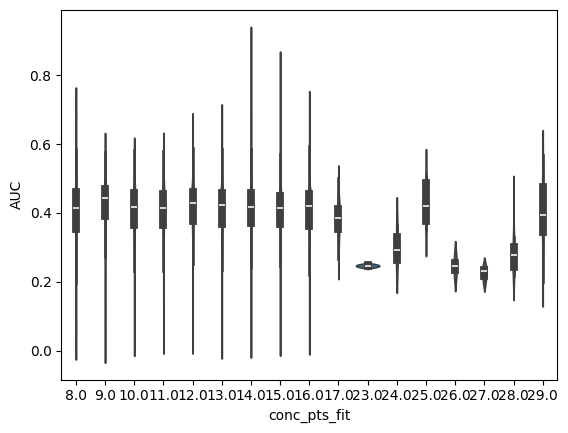

In [10]:
sns.violinplot(orig_measures_df, y="AUC", x="conc_pts_fit")

In [76]:
# merge curvecurator and original fits
mapped_response_df = viability_df[["Name", "cell_line_id", "drug_id"]].merge(mapping_df, left_on=["cell_line_id", "drug_id"], right_on=["sample", "drug"])[["Name", "experiment_id", "master_cpd_id"]].merge(orig_measures_df, on=["experiment_id", "master_cpd_id"], how='left').drop(columns=["experiment_id"])
mapped_response_df = mapped_response_df.groupby("Name").mean()
mapped_response_df = viability_df.merge(mapped_response_df, left_on=["Name"], right_index=True)

<Axes: xlabel='AUC_curvecurator', ylabel='AUC'>

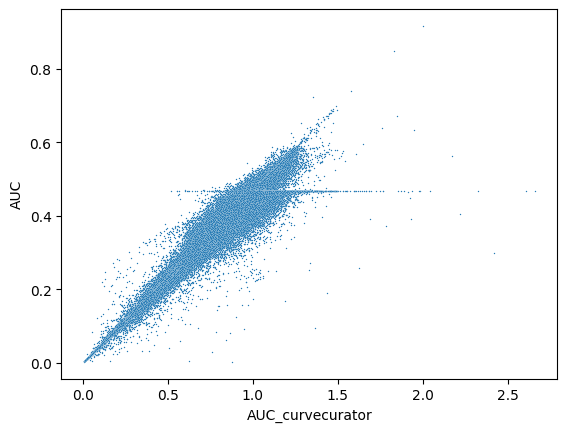

In [81]:
sns.scatterplot(mapped_response_df, x="AUC_curvecurator", y="AUC", s=1)
#plt.xlim(1e-9,1e-0)
#plt.ylim(1e-9,1e-0)

#plt.xscale('log')
#plt.yscale('log')

(1e-07, 2e+30)

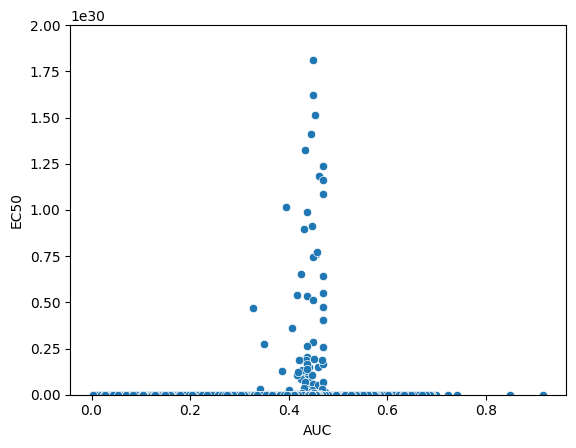

In [82]:
sns.scatterplot(mapped_response_df, x="AUC",y ="EC50")
plt.ylim(0.0000001,2e30)

(1e-07, 2e+30)

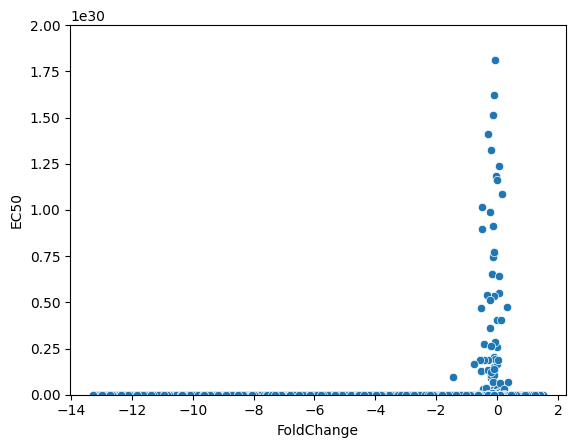

In [83]:
sns.scatterplot(mapped_response_df, x="FoldChange",y ="EC50")
plt.ylim(0.0000001,2e30)

/cmnfs/home/m.picciani/miniconda3/envs/drevalpy/lib/python3.11/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


(1e-16, 0.1)

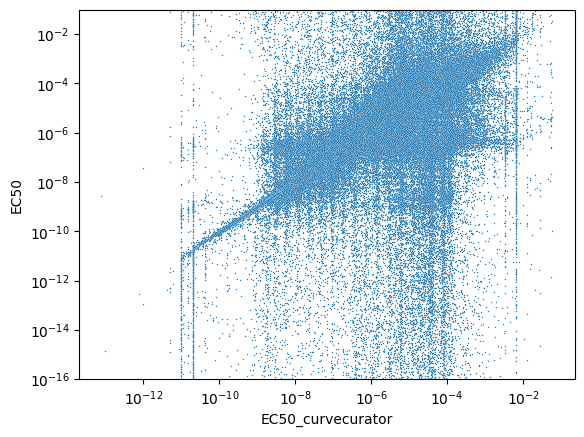

In [84]:
sns.scatterplot(mapped_response_df, x="EC50_curvecurator",y ="EC50", s=1)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-16,0.1)

In [95]:
mapped_response_df.query("EC50>1e100")

,Name,SignalQuality,pEC50_curvecurator,Slope,Front,Back,FoldChange,AUC_curvecurator,RMSE,R2,...,p4_conf_int_low,p1_center,p2_slope,p3_total_decline,p4_baseline,apparent_ec50_umol,pred_pv_high_conc,area_under_curve,EC50,AUC
1380,CVCL_0006|148198,0.0,6.506285,10.000000,0.978681,0.000100,-0.602658,0.974958,0.123499,0.276766,...,NaN,523.00,-172.2000,1.0,0.0,2.773000e+157,0.95470,14.3480,2.773000e+151,0.448375
7221,CVCL_5103|44607531,0.0,7.943939,10.000000,1.102744,1.262846,0.336679,1.226460,0.170311,0.171883,...,NaN,827.40,-0.3426,1.0,0.0,1.169000e+249,1.00000,15.0000,1.169000e+243,0.468750
7687,CVCL_1151|5702613,0.0,5.153675,10.000000,0.977263,0.863582,-0.181947,0.974743,0.096846,0.062776,...,NaN,440.60,-133.7000,1.0,0.0,4.390000e+132,0.96350,14.4700,4.390000e+126,0.452188
11179,CVCL_1169|132971,0.0,4.630534,10.000000,0.975278,0.000100,-0.093693,0.974904,0.041112,0.046747,...,NaN,793.90,-226.3000,1.0,0.0,9.411000e+238,0.97040,14.5700,9.411000e+232,0.455313
11634,CVCL_1340|73265342,0.0,8.608804,10.000000,1.016143,0.985198,-0.021514,0.989875,0.039231,0.089007,...,NaN,423.40,-91.4300,1.0,0.0,2.927000e+127,0.98990,14.8600,2.927000e+121,0.464375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382845,CVCL_1987|2126,0.0,3.026497,10.000000,0.999986,21.916264,0.093696,1.000632,0.035405,0.169814,...,NaN,940.70,-24.5900,1.0,0.0,1.485000e+283,1.00000,15.0000,1.485000e+277,0.468750
383983,CVCL_5063|252682,0.0,3.574825,4.269493,0.878884,0.784046,-0.342257,0.872499,0.082769,0.075813,...,NaN,377.80,-203.4000,1.0,0.0,5.328000e+113,0.85970,12.9610,5.328000e+107,0.405031
384199,CVCL_6805|135398744,0.0,4.013549,10.000000,1.001358,1.073621,0.102485,1.013153,0.067433,0.141456,...,NaN,465.70,-21.0600,1.0,0.0,1.563000e+140,1.00000,15.0000,1.563000e+134,0.468750
384668,CVCL_0459|2113511,0.0,3.213062,10.000000,0.954763,0.000100,-0.372724,0.952817,0.060436,0.344816,...,NaN,493.88,-147.3730,1.0,0.0,2.322500e+289,0.90805,14.1515,2.322500e+283,0.442234


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


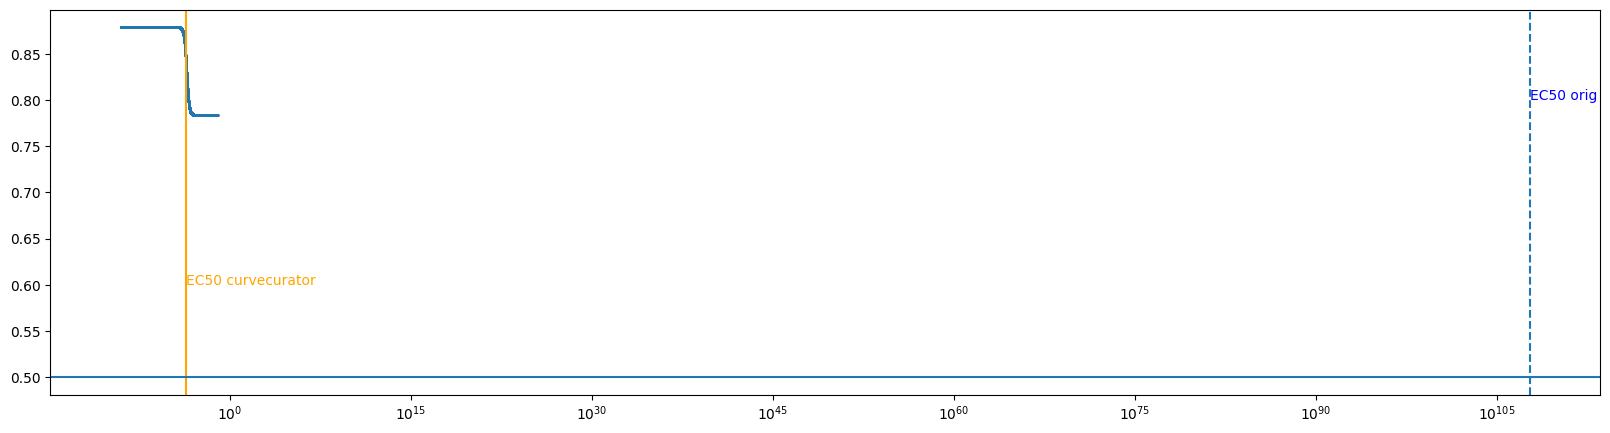

In [96]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,5))

xvals = np.linspace(-9,-1, 10000)

index = 383983
front = mapped_response_df.loc[index, "Front"]
back = mapped_response_df.loc[index, "Back"]
pec50 = mapped_response_df.loc[index, "pEC50_curvecurator"]
ec50 = mapped_response_df.loc[index, "EC50_curvecurator"]

slope = mapped_response_df.loc[index, "Slope"]
ic50 = mapped_response_df.loc[index, "IC50_curvecurator"]
#origic50 = mapped_response_df.loc[index, "IC50"]
origec50 = mapped_response_df.loc[index, "EC50"]


y = (front - back) / (1 + 10 ** (slope * (xvals + pec50))) + back
plt.scatter(10**xvals, 	y, s=1)


plt.axvline(origec50, linestyle='--')
plt.text(x=origec50, y=0.8, s='EC50 orig', color='blue')

plt.axvline(ic50, color="red")
plt.text(x=ic50, y=1.0, s='IC50 curvecurator', color='red')

plt.axvline(ec50, color="orange")
plt.text(x=ec50, y=0.6, s='EC50 curvecurator', color='orange')

plt.axhline(0.5)

plt.xscale('log')


In [97]:
mapped_response_df.to_csv("CTRPv2_for_drevalpy.csv")